In [ ]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pickle
import sys
from collections import namedtuple
from scipy.ndimage import gaussian_filter
from skimage.registration import phase_cross_correlation
from scipy.ndimage import fourier_shift
import math
import random
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from tensorflow.keras import Model, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import GlorotUniform
from scipy import interpolate

%matplotlib inline

In [ ]:
params={'xtick.labelsize':'x-large'}
plt.rcParams.update(params)
plt.rcParams['figure.dpi']=300

Code for dynamics model architecture:

In [ ]:

ki = tf.keras.initializers.RandomNormal()

class CL_ConvNeuralNet(Model):

    def __init__(self, input_dims = [14,2], output_dims=[12]):

        self.initializer =  tf.keras.initializers.he_uniform()
        self.input_dims = input_dims
        self.output_dims = output_dims
        super(CL_ConvNeuralNet, self).__init__()
        self.model = self.build_model()
        self.optimizer = tf.keras.optimizers.RMSprop()

    def build_model(self):
        InputImage = layers.Input(shape=(self.input_dims[0],1))
        InputNumeric = layers.Input(shape=(self.input_dims[1]))
        cnet = layers.Dense(512, activation=tf.nn.relu,
                               kernel_initializer=self.initializer )(InputImage)

        cnet = layers.Dense(512, activation=tf.nn.relu,
                               kernel_initializer=self.initializer )(cnet)

        cnet = layers.Dense(256, activation=tf.nn.relu,
                               kernel_initializer=self.initializer )(cnet)


        cnet = layers.Flatten()(cnet)

        cnet = Model(inputs=InputImage, outputs=cnet)

        numeric = layers.Dense(256, activation=tf.nn.relu,
                               kernel_initializer=self.initializer )(InputNumeric)

        numeric = layers.Dense(256, activation=tf.nn.relu,
                               kernel_initializer=self.initializer )(numeric)

        numeric = layers.Dense(256, activation=tf.nn.relu,
                               kernel_initializer=self.initializer )(numeric)

        numeric = Model(inputs=InputNumeric, outputs=numeric)

        combined = layers.concatenate([cnet.output, numeric.output])

        x = layers.Dense(512,activation=tf.nn.relu, kernel_initializer=self.initializer)(combined)
        x = layers.Dense(256,activation=tf.nn.relu, kernel_initializer=self.initializer)(x)
        combined_network = layers.Dense(self.output_dims[0],activation='linear',
                                        kernel_initializer=self.initializer)(x)

        model = Model(inputs=[cnet.input, numeric.input], outputs=combined_network)

        return model

    # define forward pass
    def call(self, inputs):
        prediction = self.model(inputs)[:,:]

        return prediction


Preprocessing

In [ ]:
start_pix = 55
end_pix = 70

def smooth_window(data, window_size):
    return np.convolve(data, np.ones((window_size,))/window_size, mode='valid')

def return_norm_wall_loc(am_img, start_pix = start_pix, end_pix = end_pix,
                        window_size=1):

    wps = np.zeros(shape=am_img.shape[0])
    for ind in range(am_img.shape[0]):
        wall_profile = smooth_window(am_img[ind,start_pix:end_pix], window_size)
        f = interpolate.interp1d(np.arange(len(wall_profile)), wall_profile, kind = 'nearest')
        xnew = np.linspace(0, len(wall_profile)-1, 128*10, endpoint = True)
        norm_wall_profile = np.argmax(np.diff(f(xnew)))
        subpix_max = xnew[norm_wall_profile]
        wps[ind] = subpix_max
    return wps


def normalize_images(input_images):
    return (input_images - np.min(input_images)) / (np.max(input_images) - np.min(input_images))

Dataset 1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive")

folder = r'/content/drive/My Drive'
file_name = 'wall_pulsing_revised_smaller_PTO_40deg.p'
path_to_file = os.path.join(folder, file_name)
data = pickle.load(open(path_to_file, 'rb'))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_collected = data['results']
wall_bias_locs = data['wall_locs']

pix = 128
reset_freq = 10
max_bias = 10
max_pw = 500
window_size=3

local_win_size = 7
min_ind = 0.046875
max_ind = 0.9


In [ ]:
phase_images = []
amp_images = []

for ind in range(len(data_collected)):
    output=np.asarray(data_collected[ind])
    amp_img = output[2].reshape(-1, pix*2)
    phase_img = output[3].reshape(-1, pix*2)

    amp_images.append(amp_img[:,:pix])
    phase_images.append(phase_img[:,:pix])

In [ ]:
l=0

actions = []
actions_norm = []

index_tracker =[]

for ind in range(len(data_collected)):


    if ind%reset_freq!=0:
        xpos,ypos = wall_bias_locs[l][3], wall_bias_locs[l][4]
        bias_amp, bias_pw = wall_bias_locs[l][1], wall_bias_locs[l][2]


        xpos_norm = xpos/pix
        ypos_norm = ypos/pix
        bias_amp_norm = bias_amp/max_bias
        bias_pw_norm = bias_pw/max_pw
        index_tracker.append((ind,l))
        l+=1
    else:
        xpos = np.nan
        ypos = np.nan
        xpos_norm = np.nan
        ypos_norm = np.nan
        bias_amp = np.nan
        bias_pw = np.nan
        bias_amp_norm = np.nan
        bias_pw_norm = np.nan
        zero = np.nan
        one = np.nan
        two = np.nan
        three = np.nan

    actions.append([xpos,ypos, bias_amp, bias_pw])
    actions_norm.append([xpos_norm, ypos_norm, bias_amp_norm, bias_pw_norm])



Dataset 2

In [ ]:
path = r'/content/drive/My Drive/Supplementary Domain walls/SPM Image Data/'

In [ ]:
all_img_bias=[]
for k in range(300,604):
    try:
        file_name_0 = path + 'Transition_k=' + str(k) + '.h5'
        h5_f0 = h5py.File(file_name_0, 'r+')
        bias_details0 = h5_f0['Measurement_000'].attrs['bias_details']
        h5_f0.close()
        bias_details0 = np.insert(bias_details0, 0, k)
        all_img_bias.append(bias_details0)
        k+=1
    except:
        file_name_0 = path + 'Transition_k=' + str(k) + '.h5'
        print(file_name_0)
        print("Something went wrong:", k)
        k+=1

/content/drive/My Drive/Supplementary Domain walls/SPM Image Data/Transition_k=300.h5
Something went wrong: 300
/content/drive/My Drive/Supplementary Domain walls/SPM Image Data/Transition_k=301.h5
Something went wrong: 301


In [ ]:
m=0
amp = []
phase = []
for k in range(300,604): #start,stop,step
    try:
        file_name_0 = path + 'Transition_k=' + str(k) + '.h5'
        h5_f0 = h5py.File(file_name_0, 'r+')
        qf0 = h5_f0['Measurement_000']['sho_fit']['sho_fit']

        imamp = qf0[:,:,0]
        imphase = qf0[:,:,3]
        amp.append(imamp)
        phase.append(imphase)
        h5_f0.close()
        m+=1
    except:
        print("Something went wrong:", k)

Something went wrong: 300
Something went wrong: 301
Something went wrong: 303
Something went wrong: 304


In [ ]:
#We only want the images that have associated actions, so ignore the first few
all_img_bias = all_img_bias[2:]

amp_images_new = amp
phase_images_new = phase

Dataset 1: Create transitions

In [ ]:
phase_images_segmented = np.copy(amp_images)
phase_images_segmented = normalize_images(phase_images_segmented)
phase_images_segmented[phase_images_segmented<0.2] = 0
phase_images_segmented[phase_images_segmented>=0.4] = 1

In [ ]:

transitions = []
transitions_norm = []
transitions_profiles = []
for ind in range(1, len(phase_images)):
    tnew = namedtuple('Transition', ['state','action', 'next_state'])
    tnew_norm = namedtuple('Transition', ['state','action', 'next_state'])
    tnew_prof = namedtuple('Transition', ['state','action', 'next_state'])

    tnew.state = phase_images_segmented[ind-1]
    tnew.next_state = phase_images_segmented[ind]
    tnew.action = actions[ind]

    tnew_norm.state = phase_images_segmented[ind-1]
    tnew_norm.next_state = phase_images_segmented[ind]
    tnew_norm.action = actions_norm[ind]

    state = tnew.state
    next_state = tnew.next_state
    shift, error, diffphase = phase_cross_correlation(state, next_state,
                                                  upsample_factor=3)
    offset_image = fourier_shift(np.fft.fftn(next_state), shift)
    offset_image = np.fft.ifftn(offset_image)
    next_state = offset_image.real
    wps = return_norm_wall_loc(state, window_size=window_size) + start_pix
    wps_next = return_norm_wall_loc(next_state,window_size=window_size) + start_pix

    tnew_prof.state = wps
    tnew_prof.action = tnew_norm.action
    tnew_prof.next_state = wps_next

    if not np.isnan(tnew.action[0]) and not np.isnan(actions[ind+1][0]):
        transitions.append(tnew)
        transitions_norm.append(tnew_norm)
        transitions_profiles.append(tnew_prof)

Dataset 2: Create transitions

In [ ]:
l=0
bpw = []
bamp = []
for ind in range(1,301):

    bias_amp, bias_pw = all_img_bias[l][1], all_img_bias[l][2]
    l+=1
    bpw.append(bias_pw)
    bamp.append(bias_amp)


In [ ]:
l=0
actions_new = []
actions_norm_new = []
index_tracker_new =[]

for ind in range(1,301):


    xpos,ypos = all_img_bias[l][-2], all_img_bias[l][-1]
    bias_amp, bias_pw = all_img_bias[l][1], all_img_bias[l][2]
    bias_pw=bias_pw*1000

    xpos_norm = xpos/pix
    ypos_norm = ypos/pix
    bias_amp_norm = bias_amp/max_bias
    bias_pw_norm = bias_pw/max_pw
    index_tracker.append((ind,l))
    l+=1


    actions_new.append([xpos,ypos, bias_amp, bias_pw])
    actions_norm_new.append([xpos_norm, ypos_norm, bias_amp_norm, bias_pw_norm])

In [ ]:
phase_images_segmented = np.copy(amp_images_new)
phase_images_segmented = normalize_images(phase_images_segmented)
phase_images_segmented[phase_images_segmented<0.2] = 0
phase_images_segmented[phase_images_segmented>=0.4] = 1

In [ ]:

for ind in range(1, len(phase_images_new)):
    tnew = namedtuple('Transition', ['state','action', 'next_state'])
    tnew_norm = namedtuple('Transition', ['state','action', 'next_state'])
    tnew_prof = namedtuple('Transition', ['state','action', 'next_state'])

    tnew.state = phase_images_segmented[ind-1]
    tnew.next_state = phase_images_segmented[ind]
    tnew.action = actions_new[ind]

    tnew_norm.state = phase_images_segmented[ind-1]
    tnew_norm.next_state = phase_images_segmented[ind]
    tnew_norm.action = actions_norm_new[ind]

    state = tnew.state
    next_state = tnew.next_state
    shift, error, diffphase = phase_cross_correlation(state, next_state,
                                                  upsample_factor=3)
    offset_image = fourier_shift(np.fft.fftn(next_state), shift)
    offset_image = np.fft.ifftn(offset_image)
    next_state = offset_image.real
    wps = return_norm_wall_loc(state, window_size=window_size) + start_pix
    wps_next = return_norm_wall_loc(next_state,window_size=window_size) + start_pix

    tnew_prof.state = wps
    tnew_prof.action = tnew_norm.action
    tnew_prof.next_state = wps_next

    transitions.append(tnew)
    transitions_norm.append(tnew_norm)
    transitions_profiles.append(tnew_prof)


Create batches of transitions for training

In [ ]:
local_win_size = 7
offset=5
local_state_size = 14
train_fraction = 0.80
num_training_points = len(transitions_norm)

train_split_indices = np.random.choice(np.arange(len(transitions_norm)),
                                       (int(num_training_points*train_fraction)),
                                       replace = False)

test_split_indices = [val for val in np.arange(len(transitions_norm)) if val not in train_split_indices]

#Once we have the indices we need to make the training data. X_train, y_train, X_test, y_test
#X_train is the action, state, y_train is the state+1
#Same goes for X_test and y_test
X_train, y_train, X_test, y_test = [], [], [], []

for train_ind in train_split_indices:
    transition = transitions_norm[train_ind]
    trans_profile = transitions_profiles[train_ind]
    if transition.action[1] > min_ind and transition.action[1] < max_ind:
        wall_pos = transition.action[1]*128 + offset
        wall = np.array(trans_profile.state)
        local_wall = wall[int(wall_pos - local_win_size): int(wall_pos + local_win_size)]
        local_wall = local_wall - np.mean(local_wall)
        lwall = np.zeros(local_state_size)
        lwall[:len(local_wall)] = local_wall
        lwall[len(local_wall):] = local_wall[-1]
        X_train.append([lwall, transition.action[2:]])
        difference_profile = trans_profile.next_state - trans_profile.state
        difference_profile[difference_profile>10]=10.0
        difference_profile[difference_profile<-10]=-10.0
        difference_profile = difference_profile/10
        difference_profile = difference_profile[int(wall_pos - local_win_size): int(wall_pos + local_win_size)]
        dprof = np.zeros(local_state_size)
        dprof[:len(difference_profile)] = difference_profile
        dprof[len(difference_profile):] = difference_profile[-1]
        y_train.append(smooth_window(dprof,window_size=3))

for test_ind in test_split_indices:
    transition = transitions_norm[test_ind]
    trans_profile = transitions_profiles[test_ind]
    if transition.action[1] > min_ind and transition.action[1] < max_ind:
        wall_pos = transition.action[1]*128 + offset
        wall = np.array(trans_profile.state)
        local_wall = wall[int(wall_pos - local_win_size): int(wall_pos + local_win_size)]
        local_wall = local_wall - np.mean(local_wall)
        lwall = np.zeros(local_state_size)
        lwall[:len(local_wall)] = local_wall
        lwall[len(local_wall):] = local_wall[-1]
        X_test.append([lwall, transition.action[2:]])
        difference_profile = trans_profile.next_state - trans_profile.state
        difference_profile[difference_profile>10]=10.0
        difference_profile[difference_profile<-10]=-10.0
        difference_profile = difference_profile/10
        difference_profile = difference_profile[int(wall_pos - local_win_size): int(wall_pos + local_win_size)]
        dprof = np.zeros(local_state_size)
        dprof[:len(difference_profile)] = difference_profile
        dprof[len(difference_profile):] = difference_profile[-1]
        y_test.append(smooth_window(dprof,window_size=3))

def myGenerator(batch_size = 16, num_batches = 32, image_noise = 0.001,action_noise = 0.001):
    batch_num = 0
    while batch_num < num_batches:

        train_data_slice = np.random.choice(np.arange(len(X_train)),size = batch_size, replace = False)
        validation_data_slice = np.random.choice(np.arange(len(X_test)),
                                                 size = min(8,batch_size), replace = False)

        xtrain = [X_train[int(val)] for val in train_data_slice]
        ytrain = [y_train[int(val)] for val in train_data_slice]

        xtest = [X_test[int(val)] for val in validation_data_slice]
        ytest = [y_test[int(val)] for val in validation_data_slice]

        #Convert to tensorflow arrays - training data
        xtrain_images = np.zeros(shape=(batch_size, xtrain[0][0].shape[0]))
        for ind in range(len(train_data_slice)):
            xtrain_images[ind,:] = xtrain[ind][0] + \
            np.random.normal(loc=0.0, scale = image_noise, size=(len(xtrain[ind][0])))
        xtrain_images = tf.stack(xtrain_images)

        xtrain_actions = np.zeros(shape=(batch_size, len(xtrain[0][1])))
        for ind in range(len(train_data_slice)):
            xtrain_actions[ind,:] = xtrain[ind][1]

        xtrain_actions = tf.stack(xtrain_actions)
        xtrain = [xtrain_images[:,:,None], xtrain_actions]

        #Convert to tensorflow arrays - testing data
        xtest_images = np.zeros(shape=((len(xtest)), xtest[0][0].shape[0]))
        for ind in range(len(validation_data_slice)):
            xtest_images[ind,:] = xtest[ind][0] + \
            np.random.normal(loc=0.0, scale = image_noise, size=(len(xtest[ind][0])))
        xtest_images = tf.stack(xtest_images)

        xtest_actions = np.zeros(shape=(len(xtest), len(xtest[0][1])))
        for ind in range(len(validation_data_slice)):
            xtest_actions[ind,:] = xtest[ind][1] + np.random.normal(loc=0.0, scale = action_noise,size=(2))

        xtest_actions = tf.stack(xtest_actions)

        xtest = [xtest_images[:,:,None], xtest_actions]

        yield xtrain, tf.stack(ytrain), xtest, tf.stack(ytest)
        batch_num+=1

Dynamics model training

In [20]:
ynet = CL_ConvNeuralNet()

stats = []
mygen = myGenerator(batch_size = 32, num_batches = 3000)
i=0
train_separate_branch = False
penalty=2.0
#Let's write the training
ok_spectra=0
bad_spectra=0
num_batches = 32

mse = tf.keras.losses.MeanSquaredError()

for mxtrain, mytrain, mxtest, mytest in mygen:
    with tf.GradientTape() as tape:

        prediction = ynet(mxtrain)
        actions_original = mxtrain[1][:,:]

        batch_loss=0
        for t in range(num_batches):
            local_loss=0
            Voltages=actions_original[0][:1]
            input_wall = mxtrain[0][t]

            PW=actions_original[t][1:]
            mynewtrain=mytrain[t]

            output_spectra = prediction[t,:]

            #new regularization for monotonicity
            mono_loss = 0
            test_images, test_actions = [], []
            pwidths = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

            for p in pwidths:
                 test_action_val_new_valp=p
                 test_action_val_new_valv=0.5
                 test_actions.append([test_action_val_new_valv, test_action_val_new_valp])
                 test_images.append(input_wall)
            test_input = [tf.stack(test_images), tf.stack(test_actions)]
            output = ynet(test_input)
            npoutput = output.numpy()
            arr = np.trapz((npoutput.T-npoutput.T.min()))
            for idx in range(1, len(arr)):
                if arr[idx - 1] < arr[idx]:
                    do_nothing=1
                else:
                    mono_loss+=1

            #local physics based loss penalization/regulatization
            for m in range(12):
                output_elementnp = output_spectra[m].numpy()
                mynewtrainelement = mynewtrain[m].numpy()
                output_element = output_spectra[m]
                Ratio = output_elementnp/Voltages
                if Ratio < 0: #single negative value, somethings wrong physically and we should penalize
                    bad_spectra = (mynewtrainelement- output_element)**2 * penalty
                if Ratio > 0:
                    ok_spectra = (mynewtrainelement- output_element)**2
                total_loss = (bad_spectra + ok_spectra)/12
                local_loss+=total_loss
                local_loss+=mono_loss/(i+1)
            batch_loss+=local_loss

        print("loss batch it {} is {:.5f}  ".format(i, batch_loss))


        gradients = tape.gradient(batch_loss, ynet.trainable_variables)

    ynet.optimizer.apply_gradients(zip(gradients, ynet.trainable_variables))


    i+=1


#ynet.model.save_weights('trained_surrogate_weights_phys.h5')

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer HeUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


loss batch it 0 is 2631.91602  
loss batch it 1 is 259079.34375  
loss batch it 2 is 2111.90454  
loss batch it 3 is 806.28210  
loss batch it 4 is 523.61255  
loss batch it 5 is 384.56390  
loss batch it 6 is 282.08398  
loss batch it 7 is 282.53210  
loss batch it 8 is 253.91017  
loss batch it 9 is 266.90903  
loss batch it 10 is 202.59747  
loss batch it 11 is 199.13808  
loss batch it 12 is 176.32343  
loss batch it 13 is 161.00708  
loss batch it 14 is 156.79720  
loss batch it 15 is 141.43311  
loss batch it 16 is 124.23093  
loss batch it 17 is 122.81023  
loss batch it 18 is 135.64032  
loss batch it 19 is 115.30527  
loss batch it 20 is 128.73927  
loss batch it 21 is 115.35222  
loss batch it 22 is 103.63458  
loss batch it 23 is 98.52926  
loss batch it 24 is 95.18557  
loss batch it 25 is 85.15765  
loss batch it 26 is 88.23417  
loss batch it 27 is 82.05815  
loss batch it 28 is 81.36051  
loss batch it 29 is 85.47687  
loss batch it 30 is 75.58881  
loss batch it 31 is 7

Testing

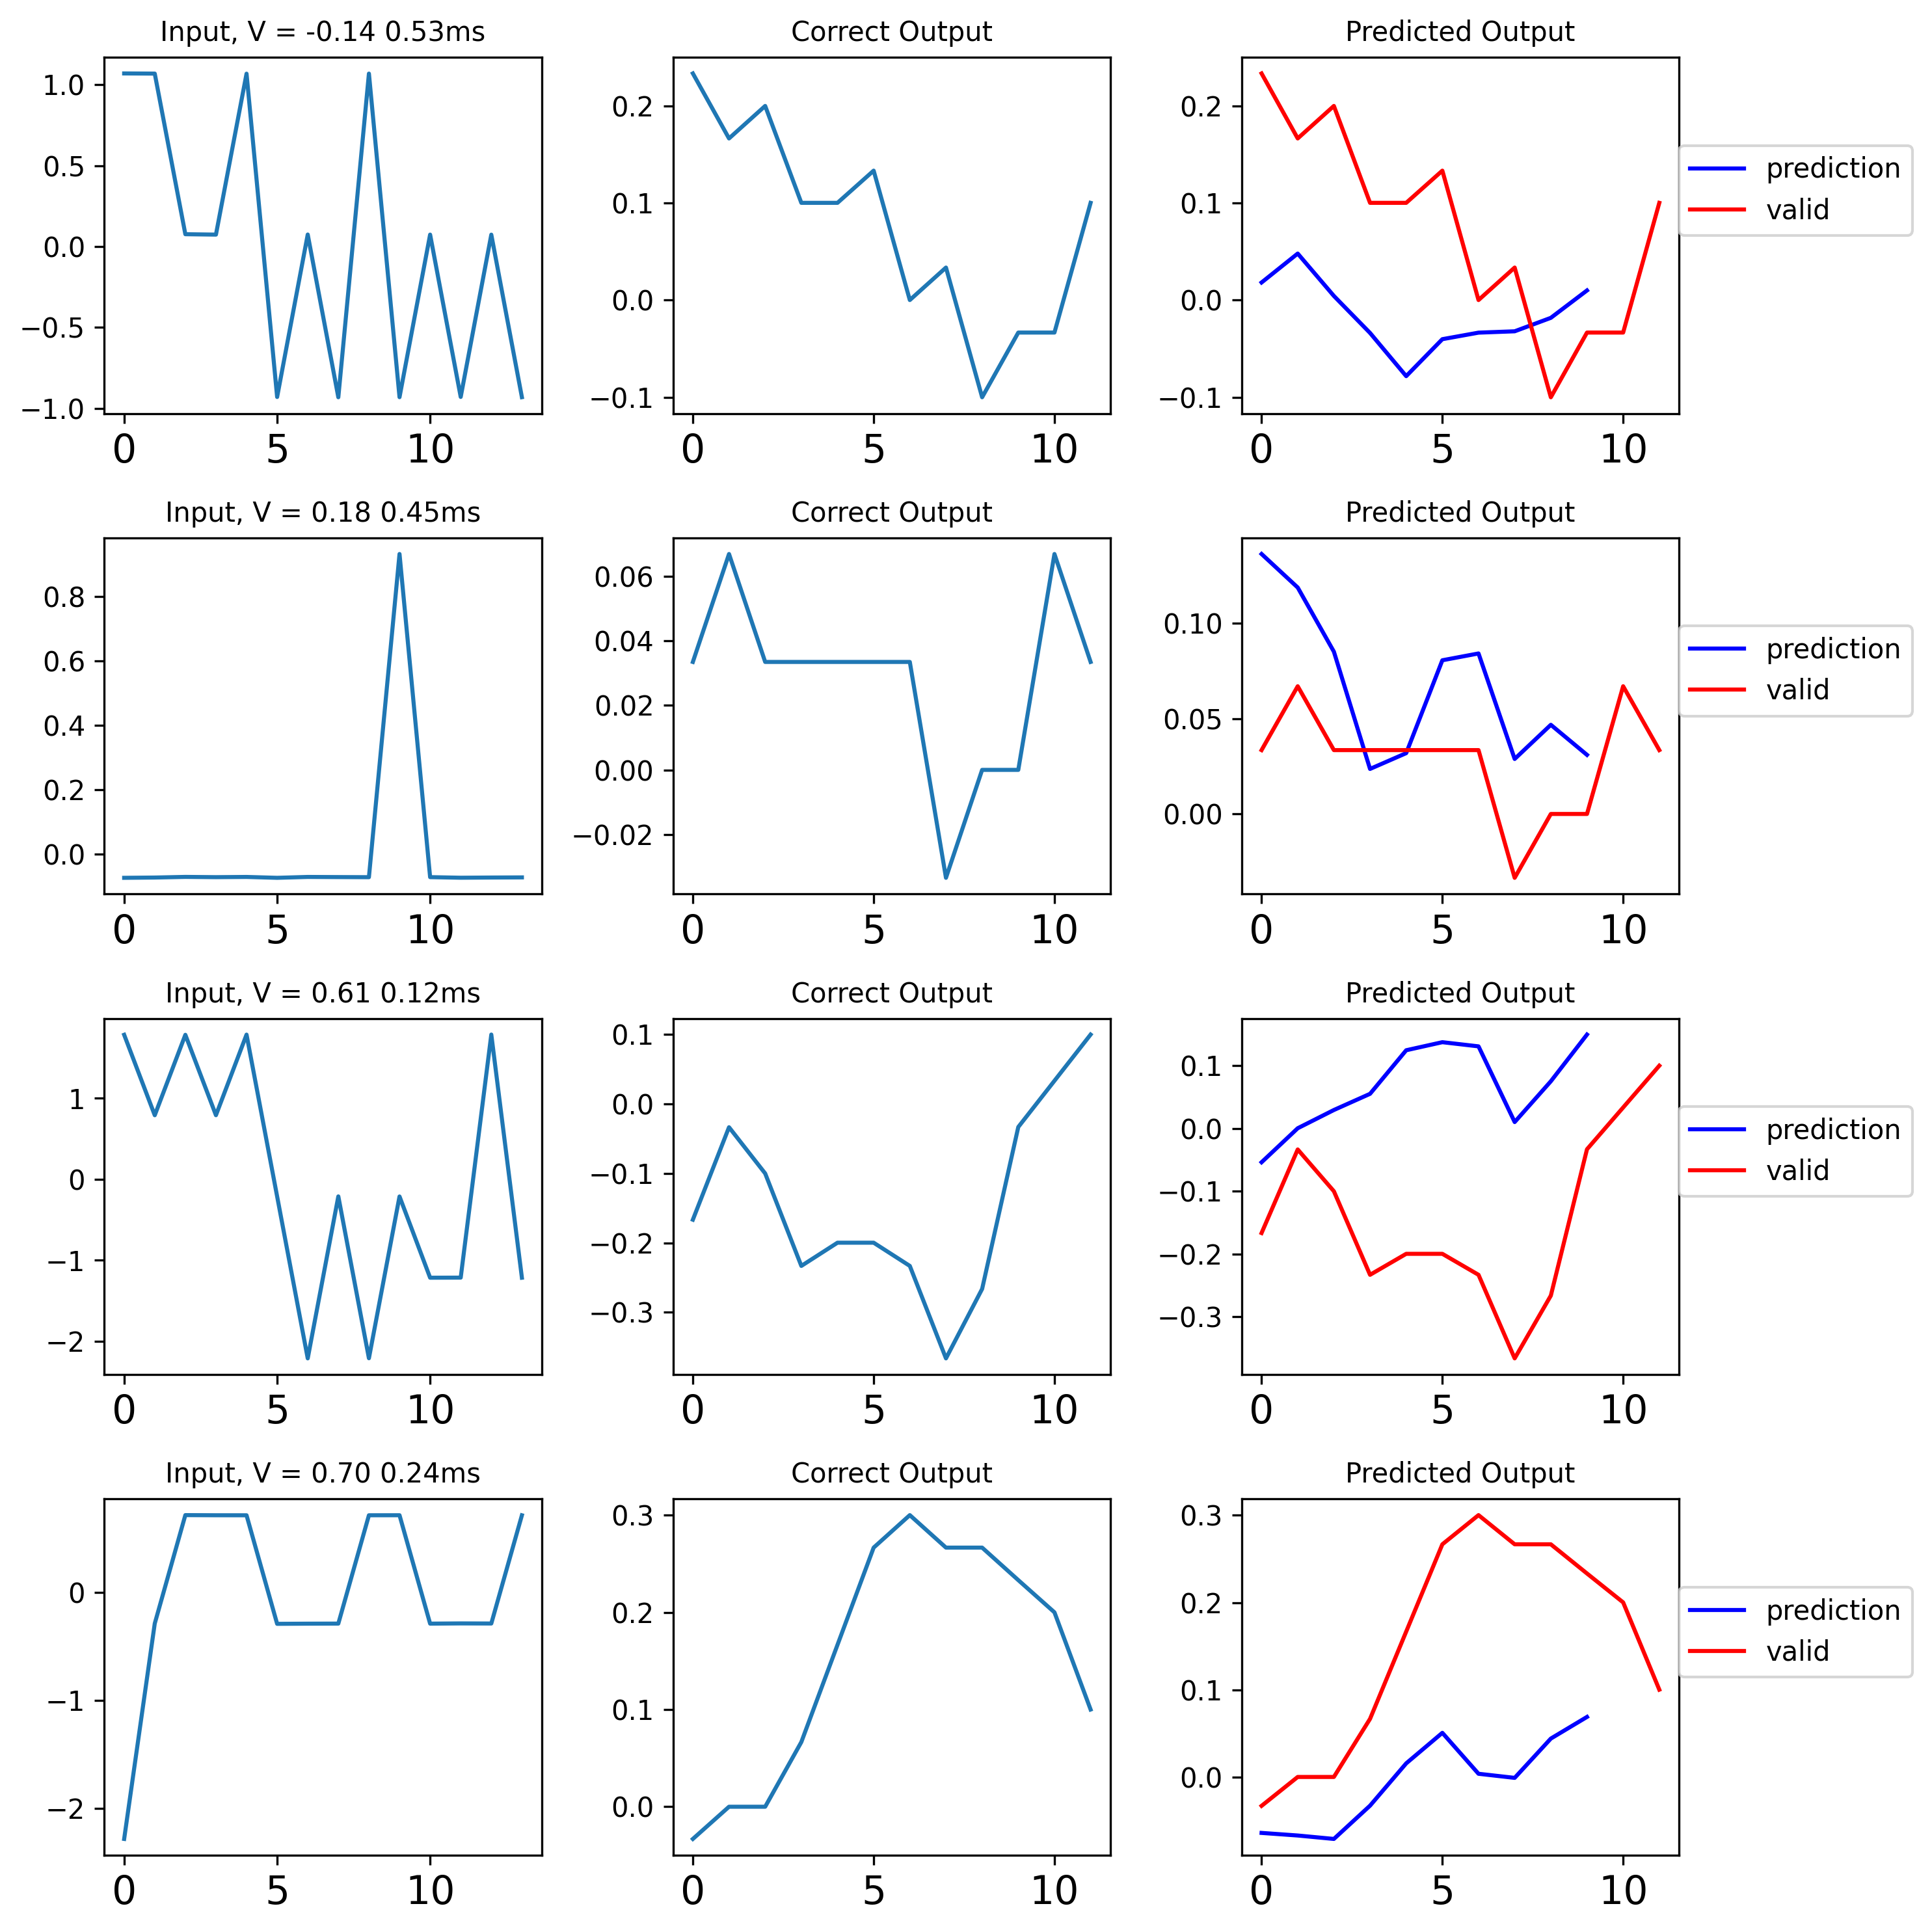

In [21]:
#Let's see what it looks like on one of the validation sets...
font_size = 10
mygen = myGenerator(batch_size = 4, num_batches = 10)

mxtrain, mytrain, mxvalid, myvalid = next(mygen)

predicted_wall = ynet(mxvalid)

fig, axes = plt.subplots(nrows=4, ncols=3, figsize = (10,10))
for row in range(4):
    axes[row,0].plot(mxvalid[0][row,:])
    vval = mxvalid[1][row,0]
    pval = mxvalid[1][row,1]

    axes[row,0].set_title('Input, V = {:.2f} {:.2f}ms'.format(vval, pval), fontsize = 10)

    axes[row,1].set_title('Correct Output', fontsize = font_size)
    axes[row,1].plot(myvalid[row][:])

    axes[row,2].plot(predicted_wall[:,:-2][row], 'b-', label = 'prediction')
    axes[row,2].plot(myvalid[row][:], 'r-', label = 'valid')
    axes[row,2].set_title('Predicted Output', fontsize = font_size)
    axes[row,2].legend(loc = [1.0, 0.5])

fig.tight_layout()

<ipython-input-22-36147f99604f>:41: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  table = actionsdf.pivot('Pulse Width (ms)', 'Voltage (V) ')


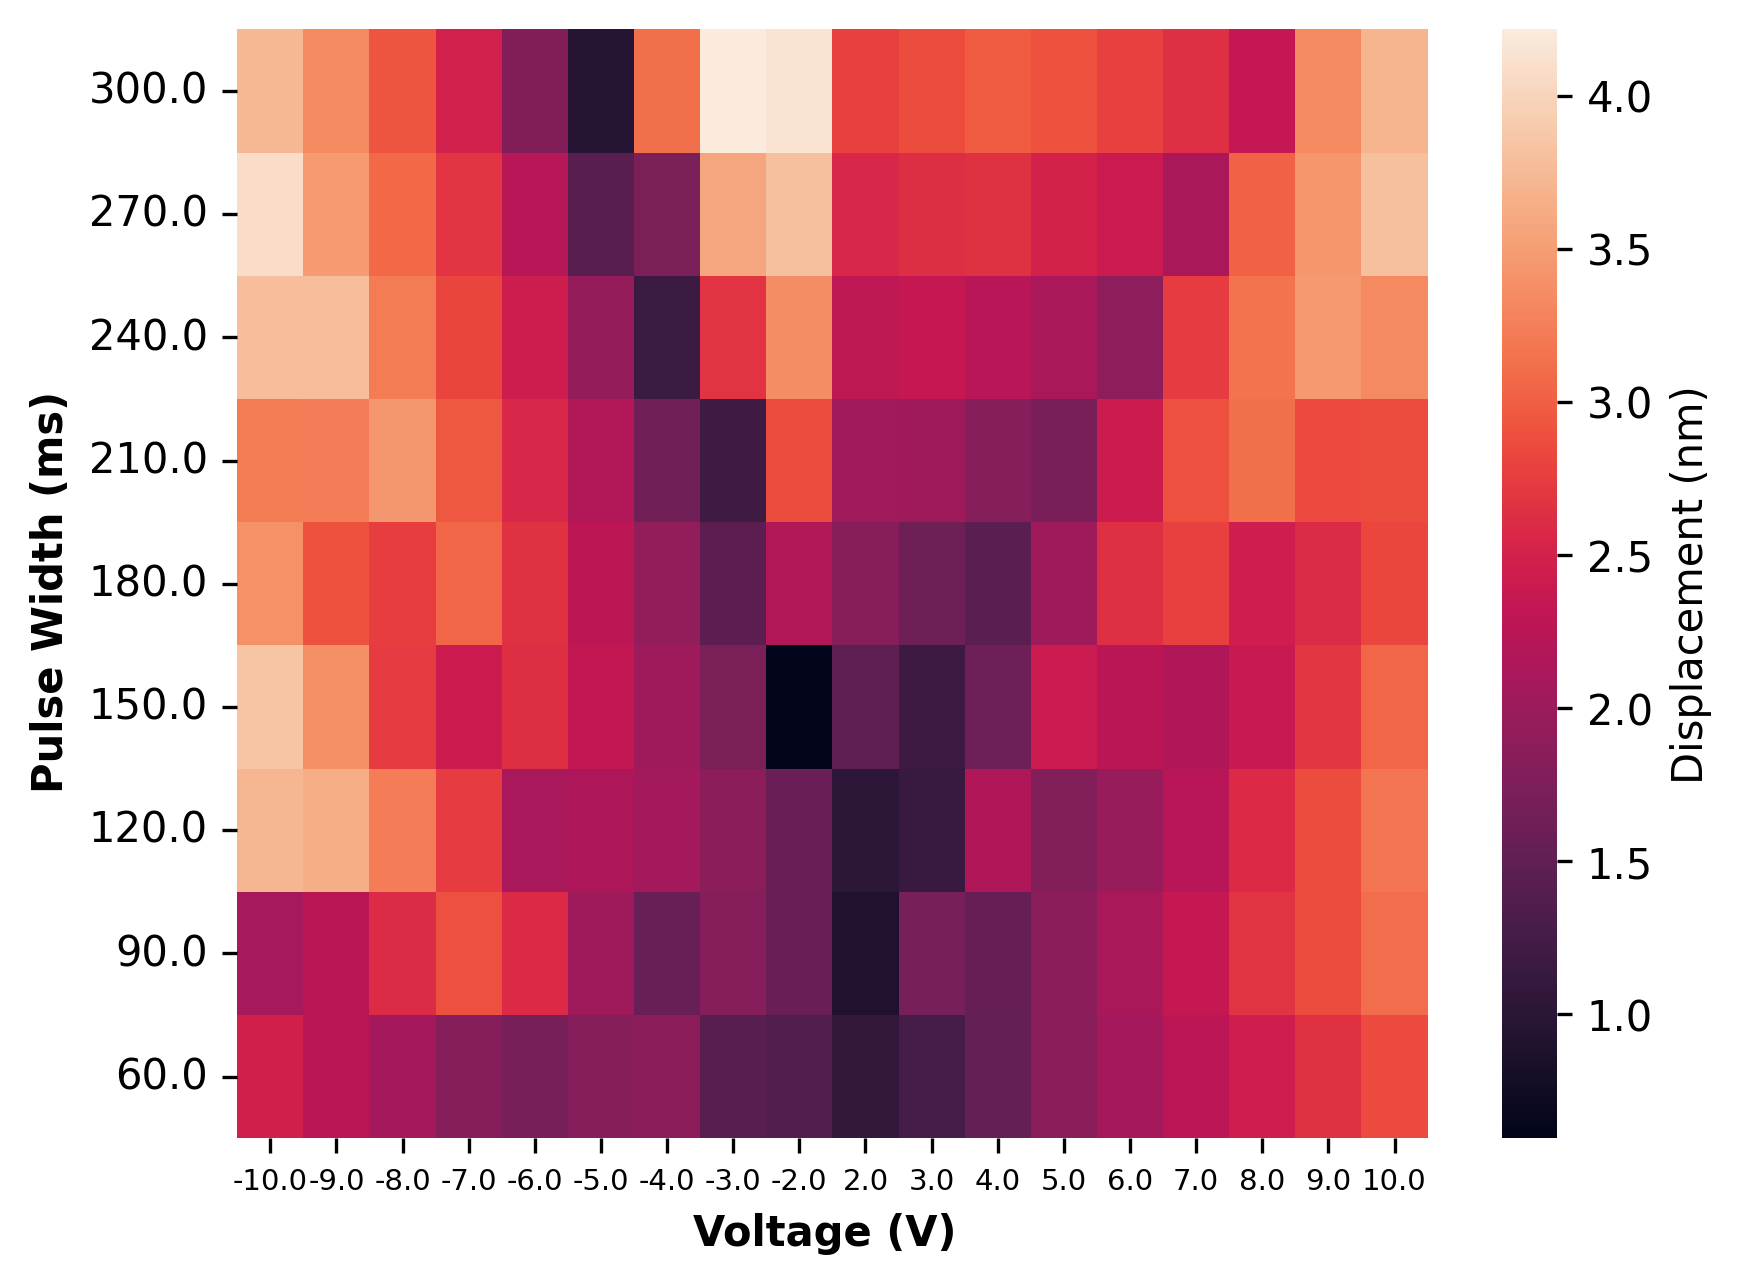

In [22]:

import pandas as pd
import seaborn as sns
#Let's take one prediction, and see how it varies with upping the bias
outputs = []

test_images, test_actions = [], []

test_image = np.full(14,-0.1)

voltages = [-1.0,-0.9,-0.8,-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

pwidths = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]


for v in voltages:
    for p in pwidths:
        test_action_val_new_valv=v
        test_action_val_new_valp=p
        test_actions.append([test_action_val_new_valv, test_action_val_new_valp])
        test_images.append(test_image)
test_input = [tf.stack(test_images), tf.stack(test_actions)]

output = ynet(test_input)

df = pd.DataFrame(output.numpy())
maxValues = df.abs().max(axis = 1)
maxValues=maxValues*7.8125 #convert to real values (nm)

new_actions = []
for i in range(len(test_actions)):
    row = test_actions[i]
    row = np.array(row)
    row[0]=row[0]*10 #convert to real values (V)
    temp=row[1]*300 #convert to real values (ms)
    row[1]=round(temp)
    new_actions.append(row)

actionsdf = pd.DataFrame (new_actions, columns = ['Voltage (V) ','Pulse Width (ms)'])
actionsdf=actionsdf.merge(maxValues.to_frame(), left_index=True, right_index=True)

table = actionsdf.pivot('Pulse Width (ms)', 'Voltage (V) ')
ax = sns.heatmap(table[0],cbar_kws={'label': 'Displacement (nm)'})
og_table=table[0]
ax.invert_yaxis()
plt.yticks(rotation = 0)
plt.xticks(fontsize=7,rotation=0)
plt.xlabel('Voltage (V) ',fontweight='bold')
plt.ylabel('Pulse Width (ms) ',fontweight='bold')
plt.show()


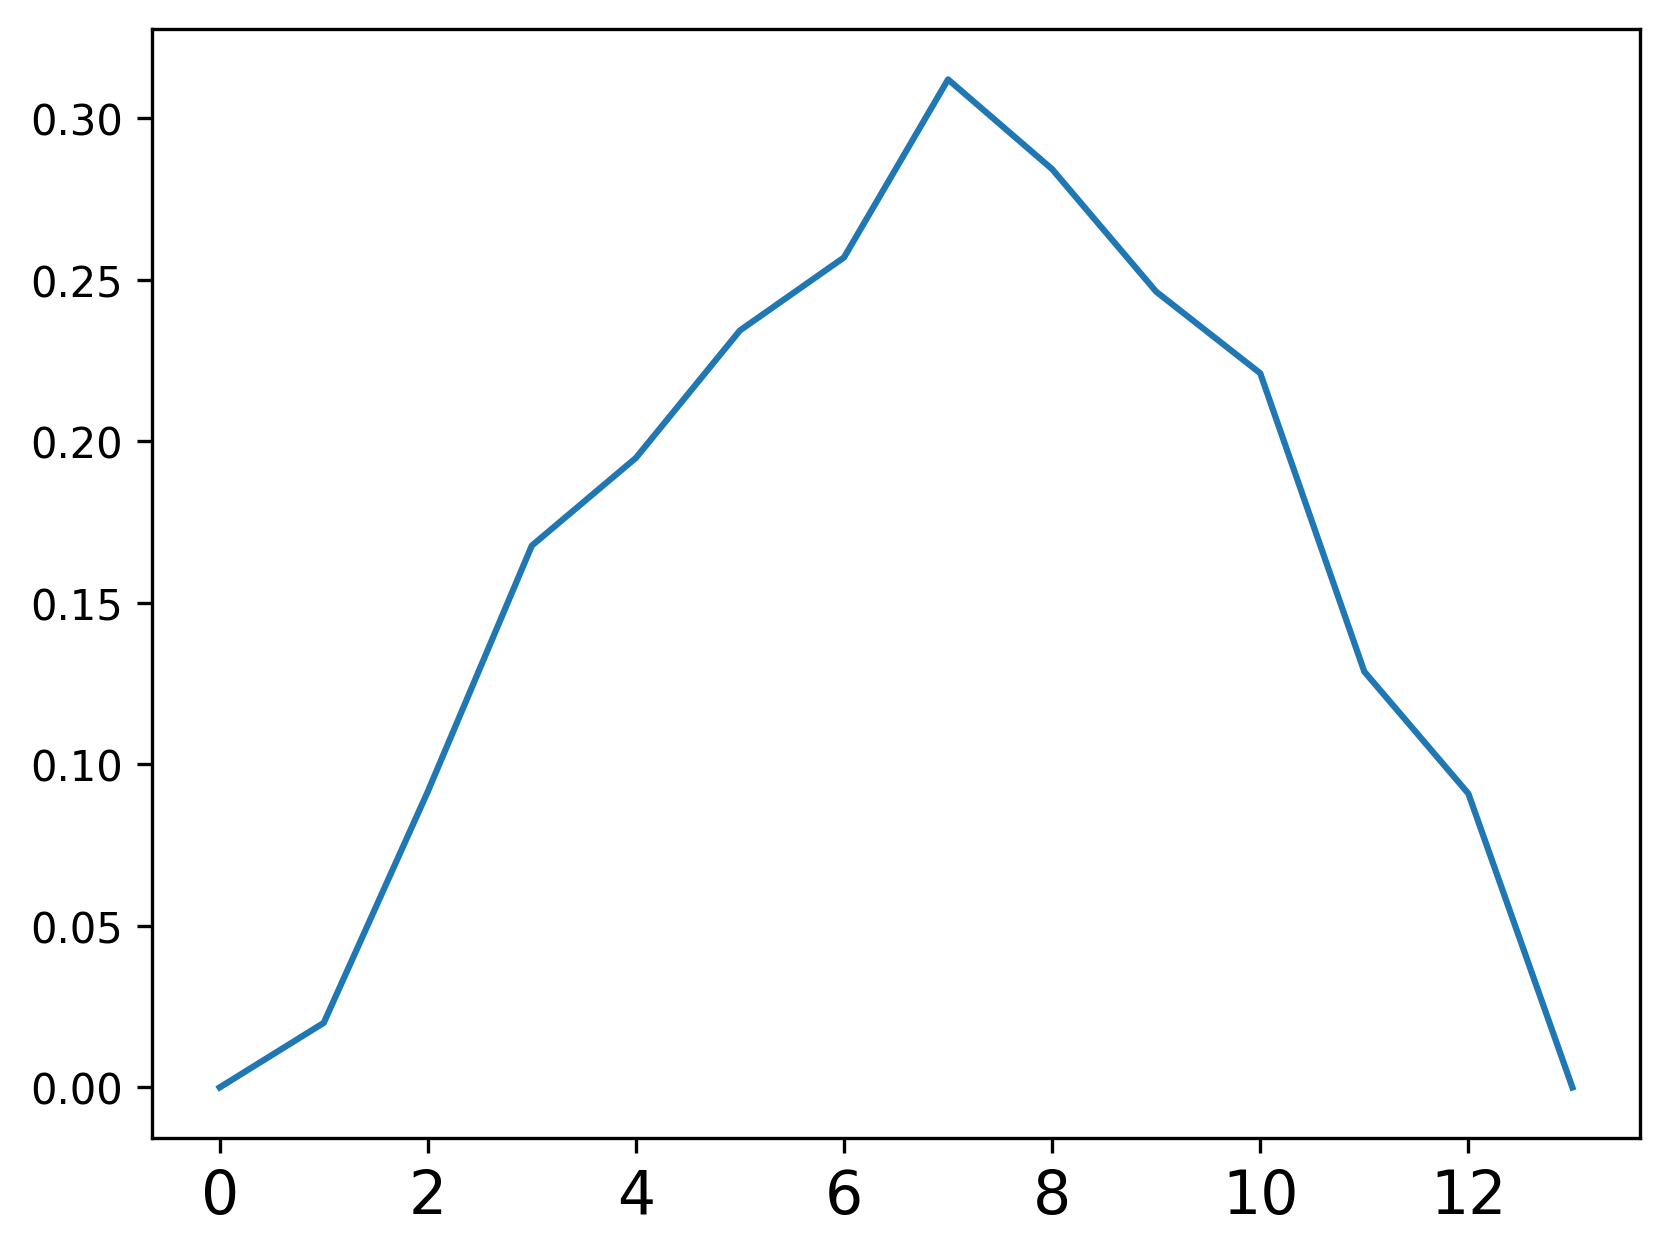

In [23]:
out = np.array(output[139])
out = np.pad(out, pad_width=1)
plt.plot(out)

<ipython-input-24-da8f72ae030f>:41: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  table = actionsdf.pivot('Pulse Width (ms)', 'Voltage (V) ')


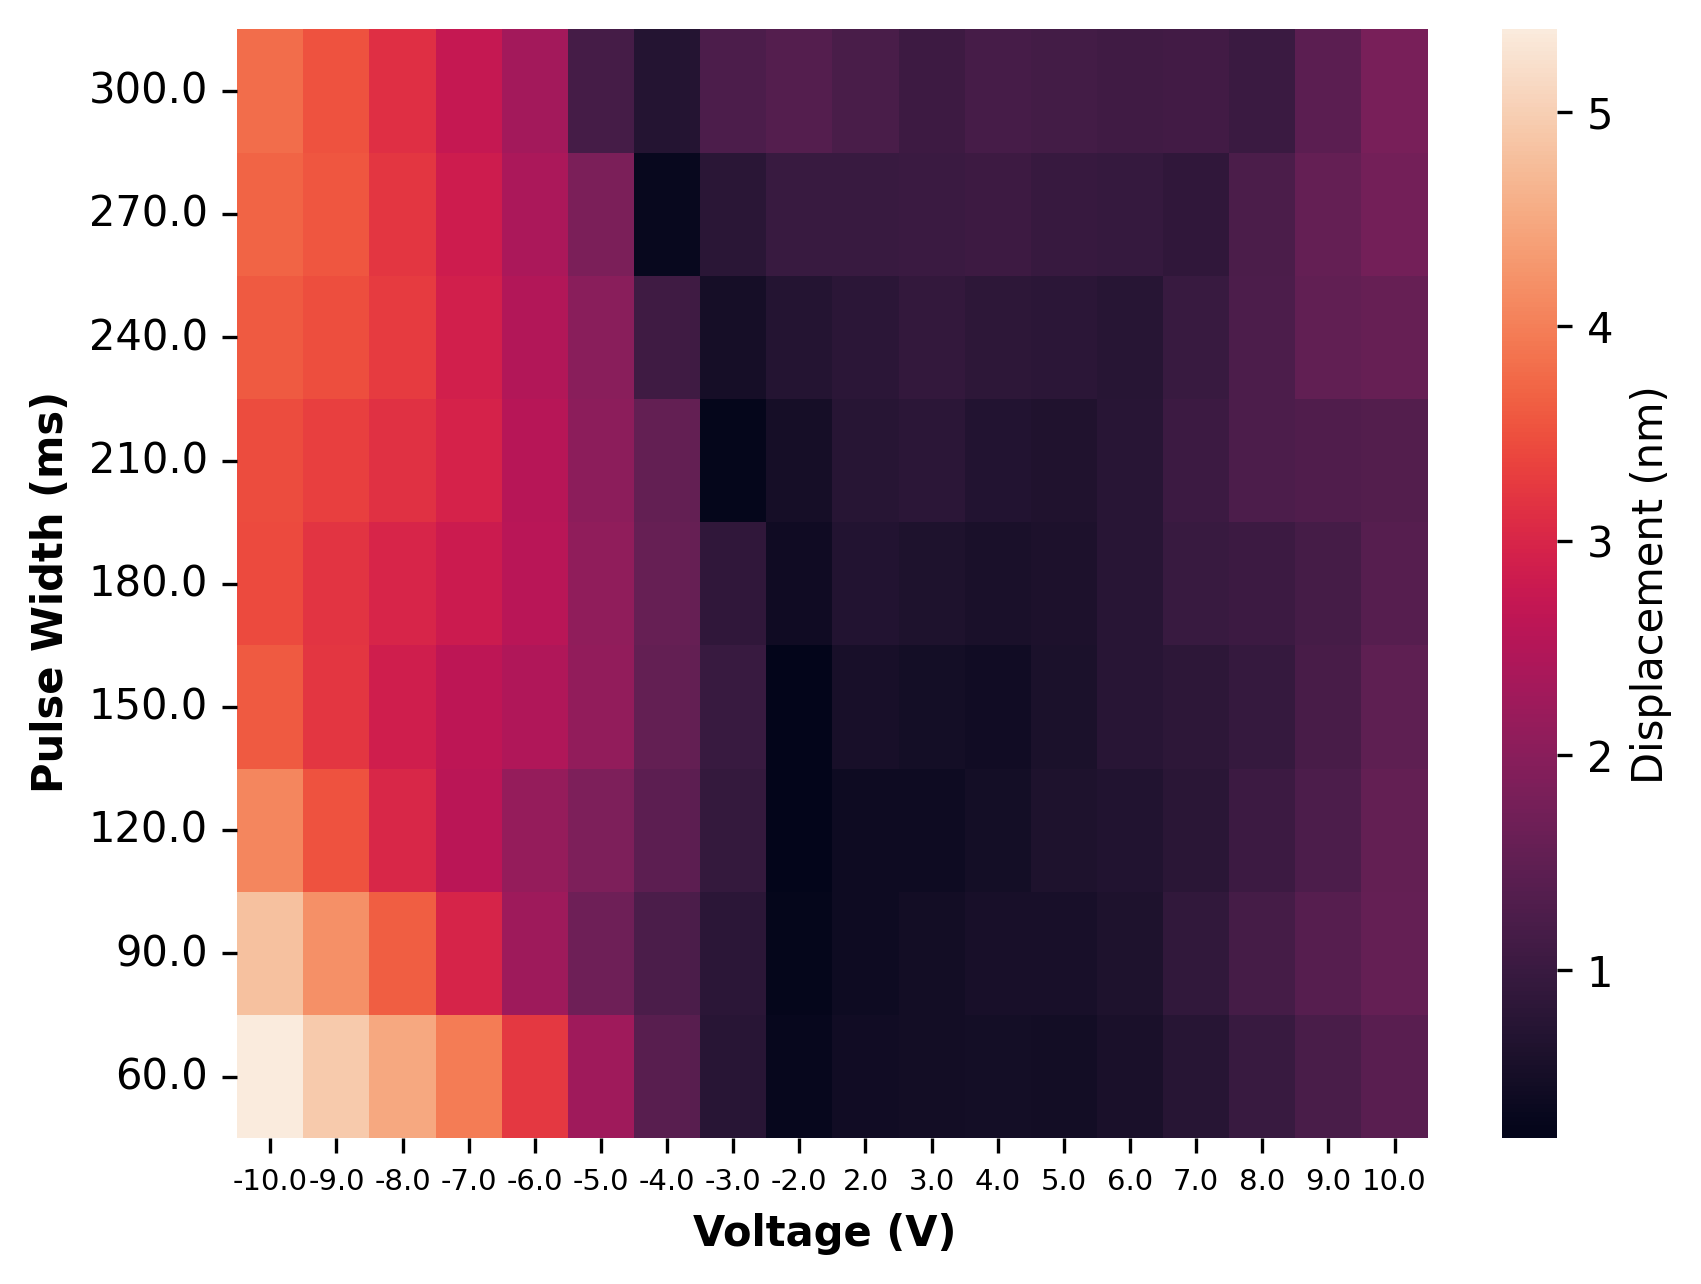

In [24]:

import pandas as pd
import seaborn as sns
#Let's take one prediction, and see how it varies with upping the bias
outputs = []

test_images, test_actions = [], []

test_image = out

voltages = [-1.0,-0.9,-0.8,-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

pwidths = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]


for v in voltages:
    for p in pwidths:
        test_action_val_new_valv=v
        test_action_val_new_valp=p
        test_actions.append([test_action_val_new_valv, test_action_val_new_valp])
        test_images.append(test_image)
test_input = [tf.stack(test_images), tf.stack(test_actions)]

output = ynet(test_input)

df = pd.DataFrame(output.numpy())
maxValues = df.abs().max(axis = 1)
maxValues=maxValues*7.8125

new_actions = []
for i in range(len(test_actions)):
    row = test_actions[i]
    row = np.array(row)
    row[0]=row[0]*10
    temp=row[1]*300
    row[1]=round(temp)
    new_actions.append(row)

actionsdf = pd.DataFrame (new_actions, columns = ['Voltage (V) ','Pulse Width (ms)'])
actionsdf=actionsdf.merge(maxValues.to_frame(), left_index=True, right_index=True)

table = actionsdf.pivot('Pulse Width (ms)', 'Voltage (V) ')
ax = sns.heatmap(table[0],cbar_kws={'label': 'Displacement (nm)'})
bulged_table = table[0]
ax.invert_yaxis()
plt.yticks(rotation = 0)
plt.xticks(fontsize=7,rotation=0)
plt.xlabel('Voltage (V) ',fontweight='bold')
plt.ylabel('Pulse Width (ms) ',fontweight='bold')
plt.show()